<a href="https://colab.research.google.com/github/AlcoholWolf/PY-SAVE/blob/main/ch05_13_%EC%82%AC%EC%9D%B4%ED%82%B7%EB%9F%B0%EC%8B%A4%EC%8A%B5_%EC%95%99%EC%83%81%EB%B8%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch05.13. 사이킷런 실습 - 앙상블

---
* 날짜:
* 이름:

## 학습내용
    - 모델 앙상블에 대한 개념을 이해한다.
    - 배깅(bagging) : 부트스트랩(bootstrp) 샘플링을 통한 분류 앙상블 기법을 이해한다.
    - 부스팅 기반의 에이다부스트(AdaBoost) 알고리즘을 이해한다.

## 학습자료
- [머신러닝 교과서 with파이썬, 사이킷런, 텐서플로](http://www.kyobobook.co.kr/product/detailViewKor.laf?mallGb=KOR&ejkGb=KOR&barcode=9791165215187)
- 7장. 다양한 모델을 결합한 앙상블 학습

```
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
```

### IN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Setting')
from setting_import import *
from setting_from import *

TemoBot | import numpy as np
TemoBot | import matplotlib.pyplot as plt
TemoBot | import pandas as pd
TemoBot | plt.style.use('dark_background')
TemoBot | import warnings / action='ignore' 
TemoBot | import matplotlib.patches as mpatches
TemoBot | import seaborn as sns
TemoBot | import time
TemoBot | import random
TemoBot | import math
TemoBot | import os
TemoBot | import scipy as sp
TemoBot | import statsmodels.api as sm
TemoBot | import requests
TemoBot | import matplotlib as mpl
TemoBot | import matplotlib.pylab as plb
TemoBot | import sklearn as sk
TemoBot | import seaborn as sns
TemoBot | from sklearn.preprocessing import All
TemoBot | from sklearn.model_selection import All
TemoBot | from sklearn.tree import All
TemoBot | from sklearn.datasets import All
TemoBot | from sklearn.linear_model import All
TemoBot | from sklearn.metrics import All
TemoBot | from sklearn.svm import All
TemoBot | from matplotlib.colors import All
TemoBot | from mpl_toolkits.mplot3d import All
TemoBot | fr

In [7]:
def PrintShape(SplitDataList):
    print('TemoBot', end = ' |   ')
    for ShapeData in SplitDataList:
        print(ShapeData.shape, end = '   |   ')

In [4]:
def draw_decision_region(model, X, y, 
                         X_test=[], y_test=[], 
                         features=[], labels=[], title=''): # 결정경계

  colors = ('orangered', 'dodgerblue', 'limegreen', 'fuchsia', 'blueviolet')
  cmap = ListedColormap(colors[:len(np.unique( y))])

  x0mn, x0mx = X[:,0].min() -1, X[:,0].max() +1
  x1mn, x1mx = X[:,1].min() -1, X[:,1].max() +1
  x0 = np.arange(x0mn, x0mx, 0.02)
  x1 = np.arange(x1mn, x1mx, 0.02)
  #print('* arange', x0.shape, x1.shape)
  X0, X1 = np.meshgrid(x0, x1)
  #print('* meshgrid', x0.shape, x1.shape)
  x0, x1 = X0.ravel(), X1.ravel()
  #print('* ravel', x0.shape, x1.shape)
  x_every = np.array([x0, x1]).T
  #print('* concat', x_set.shape)
  y_pred = model.predict(x_every)
  #print('* y_pred', y_pred.shape)
  Y_pred = y_pred.reshape(X0.shape)
  #print('* y_pred', y_pred.shape)

  if not len(labels): labels=[i for i in range(len(np.unique(y)))]
  plt.contourf(X0, X1, Y_pred, alpha=0.4, cmap=cmap )
  for idx, c in enumerate(np.unique(y)):
    plt.scatter(x = X[y == c, 0], 
                y = X[y == c, 1],
                alpha=0.8,
                c=colors[idx],
                label=labels[idx],
                marker='x',
                linewidth=2)
  if len(X_test):
    for idx, c in enumerate(np.unique(y_test)):
      plt.scatter(x = X_test[y_test == c, 0], 
                  y = X_test[y_test == c, 1],
                  alpha=0.8,
                  c=colors[idx],
                  marker='o',
                  edgecolor='k',
                  linewidth=2)
  
  if features:
    plt.xlabel(features[0])
    plt.ylabel(features[1])
  if title:
    plt.title(title)
  plt.legend()

## 데이터 소개 : 와인 데이터셋
---


```
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
```

#### 데이터 가져오기

In [13]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


#### 학습을 위한 데이터 처리
* 와인 클래스 2와 클래스 3만 사용 (1은 제거)
* 두개의 특성 Alcohol과 'OD280/OD315 of diluted wines'만 사용

In [14]:
mask = df_wine[ 'Class label' ] !=1
df_wine = df_wine[mask]

X = df_wine[ [ 'Alcohol', 'OD280/OD315 of diluted wines' ] ].values
y = df_wine[ 'Class label' ].values
PrintShape([X, y])

TemoBot |   (119, 2)   |   (119,)   |   

#### 전처리

In [49]:
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 1)

PrintShape([X_train, X_test, y_train, y_test])

TemoBot |   (95, 2)   |   (24, 2)   |   (95,)   |   (24,)   |   

#### 분포 시각화

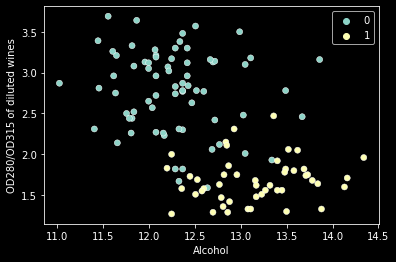

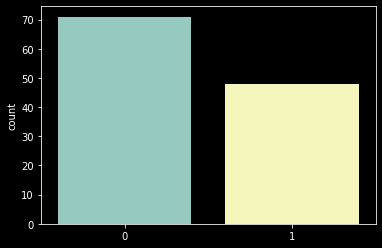

In [27]:
# 속성 1 at 2 scatter

F1 = X[ : , 0 ]
F2 = X[ : , 1 ]
sns.scatterplot( x = F1, y = F2 , hue = y , color = '#8800FF')

plt.xlabel('Alcohol')
plt.ylabel('OD280/OD315 of diluted wines')
plt.show()

# class radius = y

sns.countplot( x = y )
plt.show()

## 다수결 투표 방식을 사용한 예측
---

<p align='center'>
<img src=https://git.io/Jtskl?raw=true width=600>
</p>



#### 모델 구성

In [58]:
lr = LogisticRegression(random_state=1,
                        penalty='l2')

tree = DecisionTreeClassifier(max_depth=1, 
                              criterion='entropy', 
                              random_state=1)

knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

voting = VotingClassifier(estimators = [ ('logistic', lr),
                                        ('tree', tree),
                                        ('knn', knn) ],
                                        voting = 'soft')

models = [ 'lr', 'tree', 'knn', 'voting']

#### k-겹 교차검증

In [61]:
print('10-겹 교차검증 : ')
for model in models:
    scores = cross_val_score(estimator=eval(model), 
                             X = X_train,
                             y = y_train,
                             cv = 10,
                             scoring='accuracy',
                             )
    print(f'{model} Acc : {scores.mean():.2f} (+/- {scores.std():.2f})')

10-겹 교차검증 : 
lr Acc : 0.88 (+/- 0.13)
tree Acc : 0.88 (+/- 0.09)
knn Acc : 0.91 (+/- 0.11)
voting Acc : 0.93 (+/- 0.11)


#### 스코어 계산

In [115]:
def Voting(X_train, X_test, y_train, y_test, Score=False, CrossK=False, K=10):
    lr = LogisticRegression(random_state=1, penalty='l2')

    tree = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=1)

    knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

    voting = VotingClassifier(estimators = [ ('logistic', lr), ('tree', tree), ('knn', knn) ], voting = 'soft')

    models = [ 'lr', 'tree', 'knn', 'voting']

    if CrossK:
        print(f'{K}-겹 교차검증 : ')
        for model in models:
            scores = cross_val_score(estimator=eval(model), X = X_train, y = y_train, cv = K, scoring='accuracy')
            print(f'{model} Acc : {scores.mean():.2f} (+/- {scores.std():.2f})')

    if Score:
        for model in models:
            eval(model).fit(X_train, y_train)

            train_score = eval(model).score(X_train, y_train)
            test_score = eval(model).score(X_test, y_test)

            print(f'{model} Train_Acc : {train_score:.2f} Test_Acc : {test_score:.2f}')
            
    return models

#### 모델 별 분류경계 시각화

In [125]:
def DrawReg(X_train, X_test, y_train, y_test, models):
    plt.figure(figsize=(8,6))
    for model in models:
        draw_decision_region(eval(model),
                             X_train, y_train,
                             X_test, y_test,
                             title=model)
        plt.show()

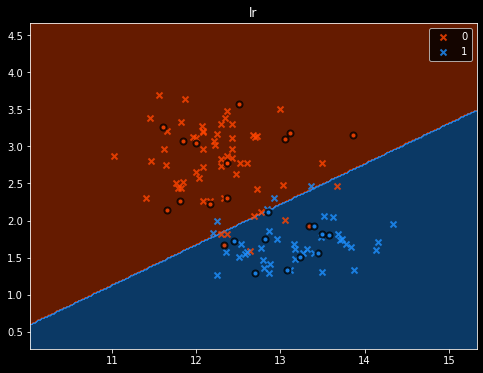

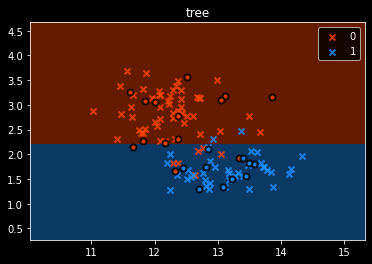

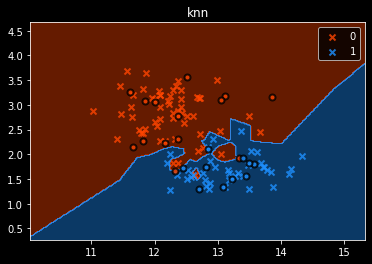

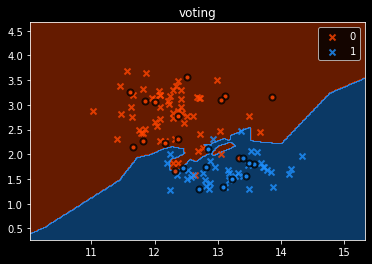

In [107]:
DrawReg(X_train, X_test, y_train, y_test, models)

## 배깅(Bagging: Bootrstrap aggregating)
----

<p align='center'>
<img src=https://git.io/Jtsk4?raw=true width=500>
</p>

#### 모델 구성

```
sklearn.ensemble.BaggingClassifier(
                                  base_estimator=None, 
                                  n_estimators=10, *, 
                                  max_samples=1.0, 
                                  max_features=1.0, 
                                  bootstrap=True, 
                                  bootstrap_features=False, 
                                  oob_score=False, 
                                  warm_start=False, 
                                  n_jobs=None, 
                                  random_state=None, 
                                  verbose=0

```

In [113]:
def Bagging(X_train, X_test, y_train, y_test, Score=False, CrossK=False, K=10):
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)
    bagging = BaggingClassifier(base_estimator=tree, n_estimators=500, random_state=1)
    models = ['tree', 'bagging']

    if CrossK:
        print(f'{K}-겹 교차검증 : ')
        for model in models:
            scores = cross_val_score(estimator=eval(model), 
                                     X = X_train,
                                     y = y_train,
                                     cv = K,
                                     scoring='accuracy',
                                     )
            print(f'{model} Acc : {scores.mean():.2f} (+/- {scores.std():.2f})')

    if Score:
        for model in models:
            eval(model).fit(X_train, y_train)

            train_score = eval(model).score(X_train, y_train)
            test_score = eval(model).score(X_test, y_test)

            print(f'{model} Train_Acc : {train_score:.2f} Test_Acc : {test_score:.2f}')
    
    return models

#### k-겹 교차검증

In [114]:
Bagging(X_train, X_test, y_train, y_test, CrossK=True)

10-겹 교차검증 : 
tree Acc : 0.88 (+/- 0.12)
bagging Acc : 0.90 (+/- 0.10)


['tree', 'bagging']

#### 스코어 계산

In [117]:
Bagging(X_train, X_test, y_train, y_test, Score=True)

tree Train_Acc : 1.00 Test_Acc : 0.83
bagging Train_Acc : 1.00 Test_Acc : 0.92


['tree', 'bagging']

#### 모델 별 분류경계 시각화

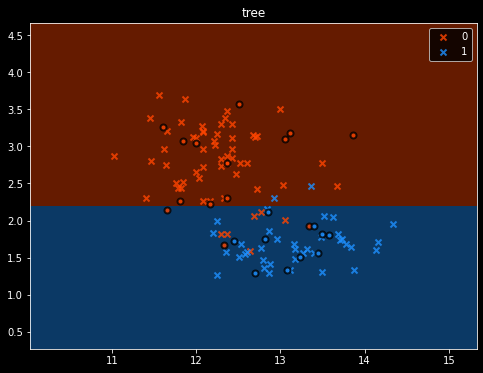

NameError: ignored

In [126]:
DrawReg(X_train, X_test, y_train, y_test, models)

##  에이다부스트(AdaBoost)
---


<p align='center'>
<img src=https://camo.githubusercontent.com/e0966809177c396bd5f64c2142e11ca7f31dfb05094ac671c5f425fbd2cd2f91/68747470733a2f2f6769742e696f2f4a74736b30?raw=true width=500>
</p>

#### 모델구성

```
class sklearn.ensemble.AdaBoostClassifier(
                          base_estimator=None, *, 
                          n_estimators=50, 
                          learning_rate=1.0, 
                          algorithm='SAMME.R', 
                          random_state=None)[source]¶

```

In [116]:
def AdaBoost(X_train, X_test, y_train, y_test, Score=False, CrossK=False, K=10):
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)
    ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=1)
    models = ['tree', 'ada']

    if CrossK:
        print(f'{K}-겹 교차검증 : ')
        for model in models:
            scores = cross_val_score(estimator=eval(model), 
                                     X = X_train,
                                     y = y_train,
                                     cv = K,
                                     scoring='accuracy',
                                     )
            print(f'{model} Acc : {scores.mean():.2f} (+/- {scores.std():.2f})')

    if Score:
        for model in models:
            eval(model).fit(X_train, y_train)

            train_score = eval(model).score(X_train, y_train)
            test_score = eval(model).score(X_test, y_test)

            print(f'{model} Train_Acc : {train_score:.2f} Test_Acc : {test_score:.2f}')
    
    return models

#### k-겹 교차검증

In [85]:
AdaBoost(X_train, X_test, y_train, y_test, Cross10=True)

10-겹 교차검증 : 
tree Acc : 0.88 (+/- 0.12)
ada Acc : 0.85 (+/- 0.13)


#### 스코어 계산

In [86]:
AdaBoost(X_train, X_test, y_train, y_test, Score=True)

tree Train_Acc : 1.00 Test_Acc : 0.83
ada Train_Acc : 1.00 Test_Acc : 0.83


#### 모델 별 분류경계 시각화

In [ ]:
plt.figure(figsize=(8,6))
for i, model in enumerate(models):
    draw_decision_region(eval(model),
                         X_train, y_train,
                         X_test, y_test,
                         title=model)
plt.show()

## 앙상블 모델 정리
---

In [127]:
from xgboost import *
from lightgbm import *

In [ ]:
lr = LogisticRegression(random_state=1, penalty='l2')
tree = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=1)
knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
voting = VotingClassifier(estimators = [ ('logistic', lr), ('tree', tree), ('knn', knn) ], voting = 'soft')
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=1)
bagging = BaggingClassifier(base_estimator=tree, n_estimators=500, random_state=1)
gbrt = GradientBoostingClassifier(random_state=1)
xgb = XGBRFClassifier(random_state=1) #
lgb = LGBMClassifier(random_state=1)

models = ['lr' ,'tree' ,'knn' ,'voting' ,'ada' ,'bagging' ,'gbrt' ,'xgb' ,'lgb']

plt.figure(figsize=(8,6))

i = 0
j = 0
for model in models:
    plt.subplot( len(models)/2, len(models)/j, i)
    draw_decision_region(eval(model),
                         X_train, y_train,
                         X_test, y_test,
                         title=model)
    i += 1
    if i == len(models)/2:
        i = 0
        ix += 1
plt.show()

#### k-겹 교차검증

#### 스코어 계산

#### 모델 별 분류경계 시각화

## 알고리즘 정해서 발표하기

1. PCA, KNN
2. 앙상블(Ensemble), 배깅(Bagging)
3. 부스팅(Bossting)

포함되어야 할 내용
- 개념 설명
- (앙상블, 배깅, 부스팅)의 경우 관련 모델
- 사이킷런 구현시 함수의 각 파라미터